In [ ]:
!pip install torchinfo -q

In [ ]:
!pip install xlstm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.0/349.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━

In [ ]:
import torch
from torch import nn
from torchinfo import summary

from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
    sLSTMLayerConfig,
    FeedForwardConfig,
)

In [ ]:
def create_xlstm_model(seq_length, num_blocks, slstm_pos, num_heads=2, conv1d_kernel_size=2, proj_factor=1.1):
    # Define your input size, hidden size, and other relevant parameters
    input_size = 1  # Number of features in your time series
    embedding_dim = 64  # Dimension of the embeddings, reduced to save memory
    output_size = 1  # Number of output features (predicting the next value)

    # Define the xLSTM configuration
    cfg = xLSTMBlockStackConfig(
        mlstm_block=mLSTMBlockConfig(
            mlstm=mLSTMLayerConfig(
                conv1d_kernel_size=conv1d_kernel_size, qkv_proj_blocksize=2, num_heads=num_heads  # Reduced parameters to save memory
            )
        ),
        slstm_block=sLSTMBlockConfig(
            slstm=sLSTMLayerConfig(
                backend="cuda",
                num_heads=num_heads,  # Reduced number of heads to save memory
                conv1d_kernel_size=conv1d_kernel_size,  # Reduced kernel size to save memory
                bias_init="powerlaw_blockdependent",
            ),
            feedforward=FeedForwardConfig(proj_factor=proj_factor, act_fn="gelu"),  # Reduced projection factor to save memory
        ),
        context_length=seq_length,
        num_blocks=num_blocks,  # Reduced number of blocks to save memory
        embedding_dim=embedding_dim,
        slstm_at=slstm_pos,
    )

    # Instantiate the xLSTM stack
    xlstm_stack = xLSTMBlockStack(cfg).to("cuda")

    # Add a linear layer to project input data to the required embedding dimension
    input_projection = nn.Linear(input_size, embedding_dim).to("cuda")

    # Add a final linear layer to project the xLSTM output to the desired output size
    output_projection = nn.Linear(embedding_dim, output_size).to("cuda")

    return xlstm_stack, input_projection, output_projection

In [ ]:
import time
from functools import wraps

def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        architecture = kwargs.get('architecture', 'Unknown Architecture')
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"\nArchitecture - {architecture} took {elapsed_time:.2f} seconds to train.")
        return result
    return wrapper

In [ ]:
from tqdm import tqdm

@timeit
def train_model(epochs, model, input_projection, output_projection, train_data, optimizer, criterion, architecture=None):

    losses = []

    print(f'Training xLSTM {architecture} for {epochs} epochs...')

    for epoch in range(epochs):
        model.train()

        epoch_loss = 0.0

        progress = tqdm(train_data, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for inputs, targets in progress:
            projected_input_data = input_projection(inputs)
            xlstm_output = model(projected_input_data)
            predictions = output_projection(xlstm_output[:, -1, :])  # Use the last time step's output

            # Ensure the shapes match
            predictions = predictions.squeeze()
            batch_y = targets.squeeze()

            # Compute the loss
            loss = criterion(predictions, batch_y)

            losses.append(loss.cpu().detach().item())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping to prevent the exploding gradient problem
            optimizer.step()

            epoch_loss += loss.item()

            progress.set_postfix(loss=loss.item())

        avg_epoch_loss = epoch_loss / len(train_data)
        print(f"Epoch {epoch+1}: Avg Loss = {avg_epoch_loss:.6f}")
        losses.append(avg_epoch_loss)

    return losses

In [ ]:
BATCH_SIZE = 3
SEQUENCE_LENGTH = 8

In [ ]:
def train_test_split(dataset, train_percent):
    train_size = int(len(dataset) * train_percent)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

    return train, test

In [ ]:
def create_dataset(dataset, seq_len=SEQUENCE_LENGTH):
    dataX, dataY = [], []

    for i in range(len(dataset) - seq_len):
        a = dataset[i:(i + seq_len - 1)]
        dataX.append(a)
        dataY.append(dataset[i + seq_len - 1])

    return torch.Tensor(dataX).to('cuda'), torch.Tensor(dataY).to('cuda')

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

def create_dataloader(x, y, is_train=True):
    return DataLoader(TensorDataset(x, y), batch_size=BATCH_SIZE, shuffle=True if is_train else False)

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(losses, title=None):
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.plot(range(len(losses)), losses)
    plt.xlabel('Num. Batch Epochs')
    plt.ylabel('Loss')
    plt.show()

In [ ]:
import numpy as np

def get_preds(model, input_projection, output_projection, test_data):
    preds = []

    model.eval()

    with torch.no_grad():
        for inputs, _ in test_data:
            projected_input_data = input_projection(inputs)
            xlstm_output = model(projected_input_data)
            predictions = output_projection(xlstm_output[:, -1, :])  # Use the last time step's output

            predictions = predictions.squeeze()
            for pred in predictions:
                preds.append(pred.cpu().item())

    return np.array(preds).reshape(-1, 1)

In [ ]:
def plot_original_vs_predicted(original, predicted, scaler, title=None):
    preds_rescaled = scaler.inverse_transform(predicted)
    original_rescaled = scaler.inverse_transform(original.cpu().numpy())

    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.plot(range(len(preds_rescaled)), preds_rescaled, linestyle='--', c='r', label='Predicted')
    plt.plot(range(len(original_rescaled)), original_rescaled, c='b', label='Original')

    plt.legend()
    plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse

def get_mae_mse(original, predicted, scaler):
    preds_rescaled = scaler.inverse_transform(predicted).flatten()
    original_rescaled = scaler.inverse_transform(original.cpu().numpy()).flatten()

    return mae(y_true=original_rescaled, y_pred=preds_rescaled), mse(y_true=original_rescaled, y_pred=preds_rescaled)

# Recreating RIL Data Prediction

In [ ]:
import os
import pandas as pd

DATASET_PATH = '/content/drive/MyDrive/datasets/RIL'

In [ ]:
os.listdir(DATASET_PATH)

['Copy of Quote-Equity-RELIANCE-EQ-26-04-2024-to-26-04-2025.csv',
 'Copy of Quote-Equity-RELIANCE-EQ-26-04-2021-to-26-04-2022.csv',
 'Copy of Quote-Equity-RELIANCE-EQ-26-04-2019-to-26-04-2020.csv',
 'Copy of Quote-Equity-RELIANCE-EQ-26-04-2022-to-26-04-2023.csv',
 'Copy of Quote-Equity-RELIANCE-EQ-26-04-2023-to-26-04-2024.csv',
 'Copy of Quote-Equity-RELIANCE-EQ-26-04-2020-to-26-04-2021.csv']

In [ ]:
df = pd.concat([pd.read_csv(os.path.join(DATASET_PATH, file), thousands=',', usecols=['close ']) for file in os.listdir(DATASET_PATH)])

In [ ]:
df

,close
0,1300.40
1,1301.60
2,1300.00
3,1291.20
4,1295.50
...,...
245,1435.20
246,1466.00
247,1426.95
248,1428.15


In [ ]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()

dataset = mm.fit_transform(df.values.astype('float32'))

In [ ]:
train, test = train_test_split(dataset, train_percent=0.70)

In [ ]:
trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)

train_loader = create_dataloader(trainX, trainY)
test_loader = create_dataloader(testX, testY, is_train=False)

<ipython-input-9-3789e1548c67>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.Tensor(dataX).to('cuda'), torch.Tensor(dataY).to('cuda')


## `[m, s]` Structure

In [ ]:
from torch.optim import Adam

num_epochs = 5

xlstm_stack, input_projection, output_projection = create_xlstm_model(SEQUENCE_LENGTH, num_blocks=2, slstm_pos=[1])
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = Adam(list(xlstm_stack.parameters()) + list(input_projection.parameters()) + list(output_projection.parameters()), lr=0.0001)

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py311_cu124/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/usr/local/lib/python3.11/dist-p

In [ ]:
summary(xlstm_stack)

Layer (type:depth-idx)                             Param #
xLSTMBlockStack                                    --
├─ModuleList: 1-1                                  --
│    └─mLSTMBlock: 2-1                             --
│    │    └─LayerNorm: 3-1                         64
│    │    └─mLSTMLayer: 3-2                        27,524
│    └─sLSTMBlock: 2-2                             --
│    │    └─LayerNorm: 3-3                         64
│    │    └─sLSTMLayer: 3-4                        16,896
│    │    └─LayerNorm: 3-5                         64
│    │    └─GatedFeedForward: 3-6                  24,576
├─LayerNorm: 1-2                                   64
Total params: 69,252
Trainable params: 69,252
Non-trainable params: 0

In [ ]:
next(iter(train_loader))[0].shape

torch.Size([3, 7, 1])

In [ ]:
losses = train_model(num_epochs, xlstm_stack, input_projection, output_projection, train_loader, optimizer, criterion, architecture='[m, s]')

Training xLSTM [m, s] for 5 epochs...


Epoch 1: Avg Loss = 0.003943


Epoch 2: Avg Loss = 0.001223


Epoch 3: Avg Loss = 0.000986


Epoch 4: Avg Loss = 0.001107


Epoch 5: Avg Loss = 0.001212

Architecture - [m, s] took 26.79 seconds to train.


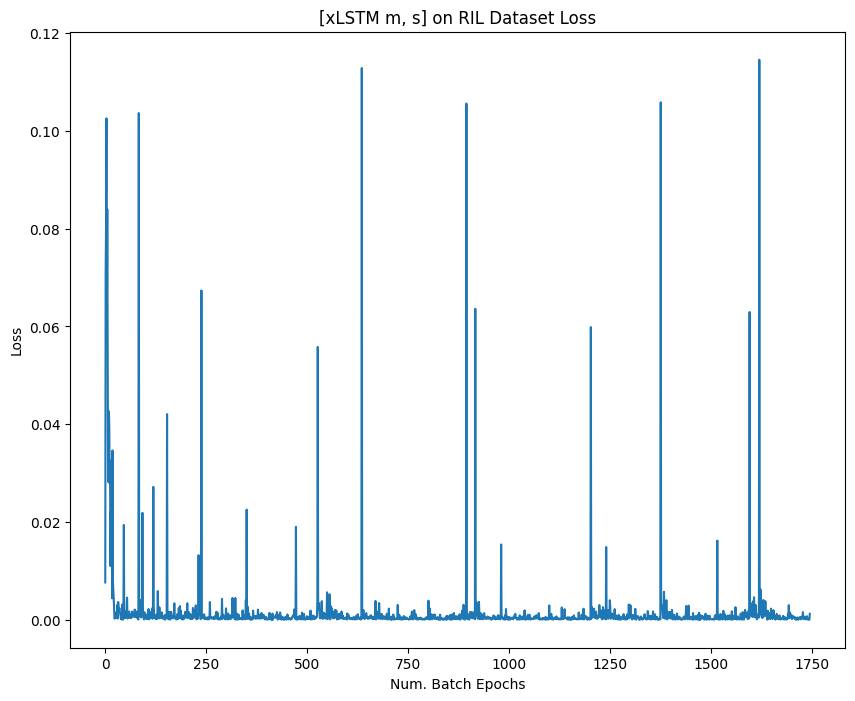

In [ ]:
plot_losses(losses, title='[xLSTM m, s] on RIL Dataset Loss')

In [ ]:
preds_xlstm_ms = get_preds(xlstm_stack, input_projection, output_projection, test_loader)

In [ ]:
mean_sq_err, mean_abs_err = get_mae_mse(testY, preds_xlstm_ms, mm)

mean_sq_err, mean_abs_err

(29.52359780434034, 1967.567989090904)

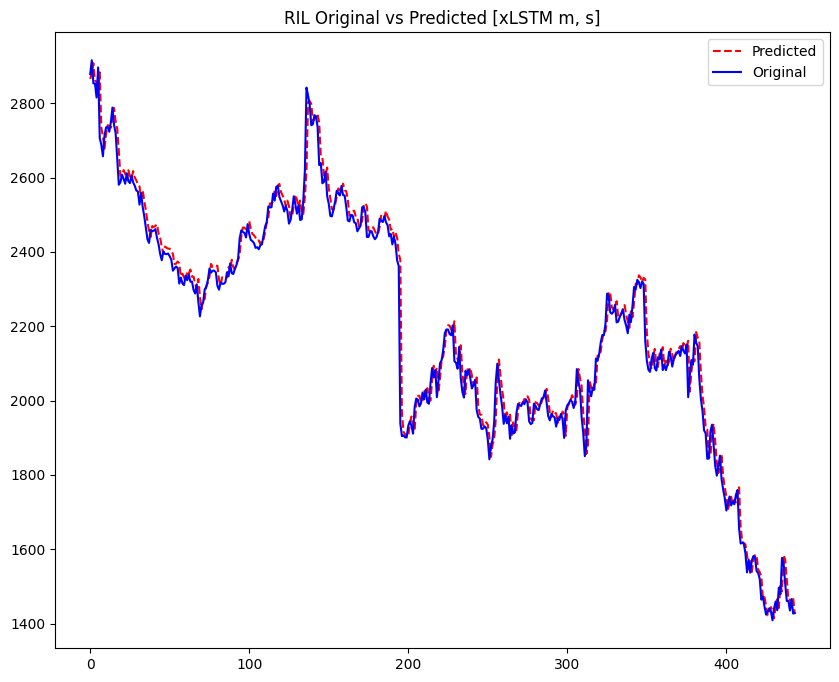

In [ ]:
plot_original_vs_predicted(testY, preds_xlstm_ms, mm, 'RIL Original vs Predicted [xLSTM m, s]')

## `[m]` Structure

In [ ]:
from torch.optim import Adam

num_epochs = 5

xlstm_stack, input_projection, output_projection = create_xlstm_model(SEQUENCE_LENGTH, num_blocks=1, slstm_pos=[])
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = Adam(list(xlstm_stack.parameters()) + list(input_projection.parameters()) + list(output_projection.parameters()), lr=0.0001)

In [ ]:
summary(xlstm_stack)

Layer (type:depth-idx)                             Param #
xLSTMBlockStack                                    --
├─ModuleList: 1-1                                  --
│    └─mLSTMBlock: 2-1                             --
│    │    └─LayerNorm: 3-1                         64
│    │    └─mLSTMLayer: 3-2                        27,524
├─LayerNorm: 1-2                                   64
Total params: 27,652
Trainable params: 27,652
Non-trainable params: 0

In [ ]:
losses = train_model(num_epochs, xlstm_stack, input_projection, output_projection, train_loader, optimizer, criterion, architecture='[m]')

Training xLSTM [m] for 5 epochs...


Epoch 1: Avg Loss = 0.011499


Epoch 2: Avg Loss = 0.001377


Epoch 3: Avg Loss = 0.001252


Epoch 4: Avg Loss = 0.001010


Epoch 5: Avg Loss = 0.001020

Architecture - [m] took 16.63 seconds to train.


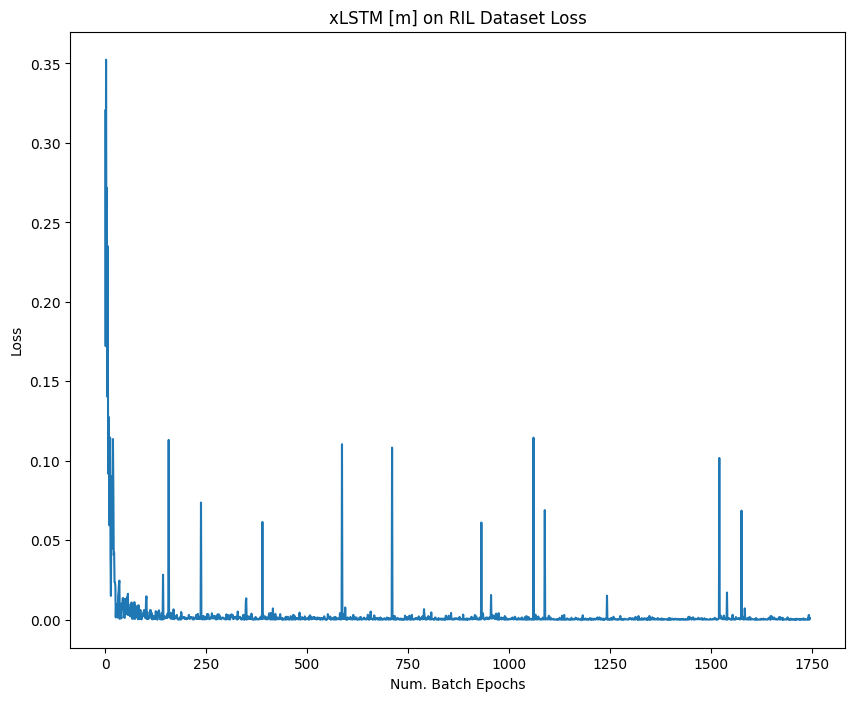

In [ ]:
plot_losses(losses, title='xLSTM [m] on RIL Dataset Loss')

In [ ]:
preds_xlstm_m = get_preds(xlstm_stack, input_projection, output_projection, test_loader)

In [ ]:
mean_sq_err, mean_abs_err = get_mae_mse(testY, preds_xlstm_m, mm)

mean_sq_err, mean_abs_err

(40.312095238641376, 2965.304760424822)

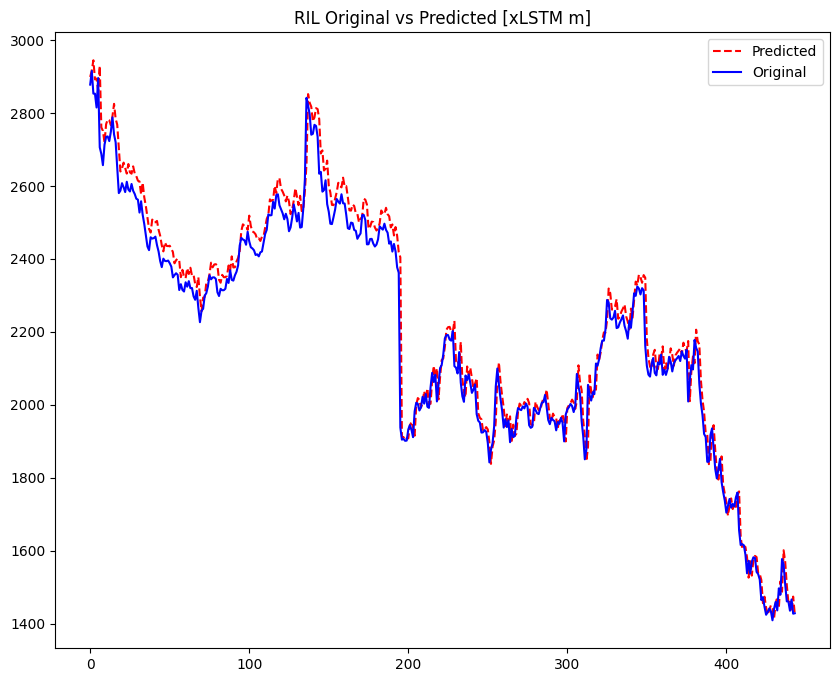

In [ ]:
plot_original_vs_predicted(testY, preds_xlstm_m, mm, 'RIL Original vs Predicted [xLSTM m]')

## `[s]` Structure

In [ ]:
from torch.optim import Adam

num_epochs = 5

xlstm_stack, input_projection, output_projection = create_xlstm_model(SEQUENCE_LENGTH, num_blocks=1, slstm_pos=[0])
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = Adam(list(xlstm_stack.parameters()) + list(input_projection.parameters()) + list(output_projection.parameters()), lr=0.0001)

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(


In [ ]:
summary(xlstm_stack)

Layer (type:depth-idx)                             Param #
xLSTMBlockStack                                    --
├─ModuleList: 1-1                                  --
│    └─sLSTMBlock: 2-1                             --
│    │    └─LayerNorm: 3-1                         64
│    │    └─sLSTMLayer: 3-2                        16,896
│    │    └─LayerNorm: 3-3                         64
│    │    └─GatedFeedForward: 3-4                  24,576
├─LayerNorm: 1-2                                   64
Total params: 41,664
Trainable params: 41,664
Non-trainable params: 0

In [ ]:
losses = train_model(num_epochs, xlstm_stack, input_projection, output_projection, train_loader, optimizer, criterion, architecture='[s]')

Training xLSTM [s] for 5 epochs...


Epoch 1: Avg Loss = 0.006620


Epoch 2: Avg Loss = 0.001082


Epoch 3: Avg Loss = 0.001004


Epoch 4: Avg Loss = 0.001041


Epoch 5: Avg Loss = 0.001001

Architecture - [s] took 15.42 seconds to train.


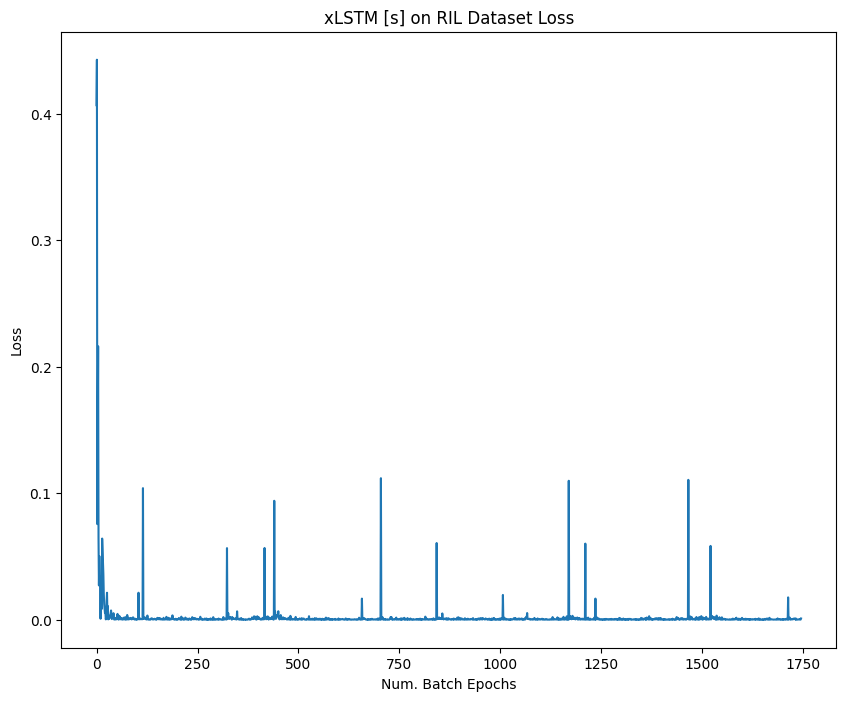

In [ ]:
plot_losses(losses, title='xLSTM [s] on RIL Dataset Loss')

In [ ]:
preds_xlstm_s = get_preds(xlstm_stack, input_projection, output_projection, test_loader)

In [ ]:
mean_sq_err, mean_abs_err = get_mae_mse(testY, preds_xlstm_m, mm)

mean_sq_err, mean_abs_err

(40.312095238641376, 2965.304760424822)

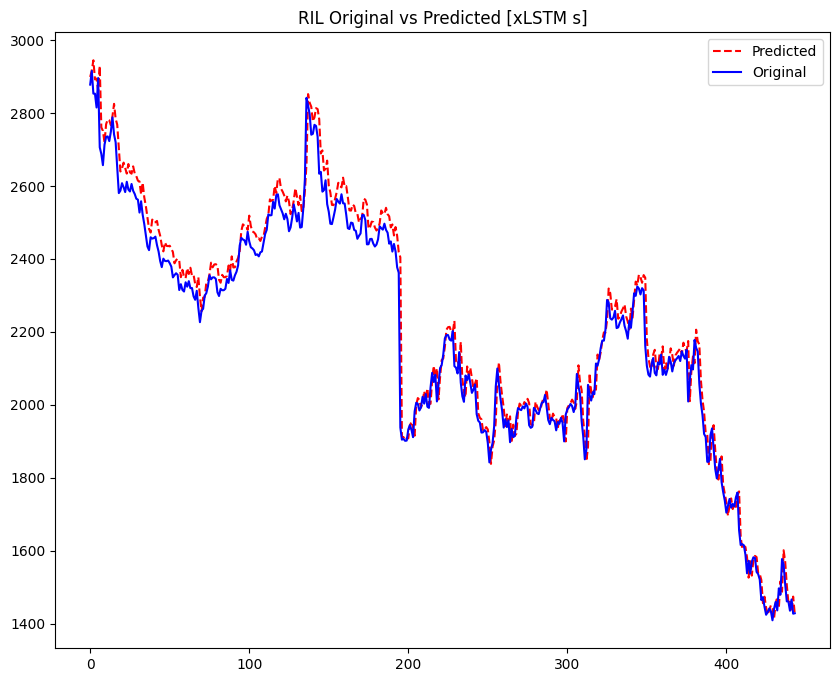

In [ ]:
plot_original_vs_predicted(testY, preds_xlstm_m, mm, 'RIL Original vs Predicted [xLSTM s]')

## `[msm]` Structure

In [ ]:
from torch.optim import Adam

num_epochs = 5

xlstm_stack, input_projection, output_projection = create_xlstm_model(SEQUENCE_LENGTH, num_blocks=3, slstm_pos=[1])
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = Adam(list(xlstm_stack.parameters()) + list(input_projection.parameters()) + list(output_projection.parameters()), lr=0.0001)

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(


In [ ]:
summary(xlstm_stack)

Layer (type:depth-idx)                             Param #
xLSTMBlockStack                                    --
├─ModuleList: 1-1                                  --
│    └─mLSTMBlock: 2-1                             --
│    │    └─LayerNorm: 3-1                         64
│    │    └─mLSTMLayer: 3-2                        27,524
│    └─sLSTMBlock: 2-2                             --
│    │    └─LayerNorm: 3-3                         64
│    │    └─sLSTMLayer: 3-4                        16,896
│    │    └─LayerNorm: 3-5                         64
│    │    └─GatedFeedForward: 3-6                  24,576
│    └─mLSTMBlock: 2-3                             --
│    │    └─LayerNorm: 3-7                         64
│    │    └─mLSTMLayer: 3-8                        27,524
├─LayerNorm: 1-2                                   64
Total params: 96,840
Trainable params: 96,840
Non-trainable params: 0

In [ ]:
losses = train_model(num_epochs, xlstm_stack, input_projection, output_projection, train_loader, optimizer, criterion, architecture='[m, s, m]')

Training xLSTM [m, s, m] for 5 epochs...


Epoch 1: Avg Loss = 0.046406


Epoch 2: Avg Loss = 0.001061


Epoch 3: Avg Loss = 0.001018


Epoch 4: Avg Loss = 0.001085


Epoch 5: Avg Loss = 0.001023

Architecture - [m, s, m] took 35.56 seconds to train.


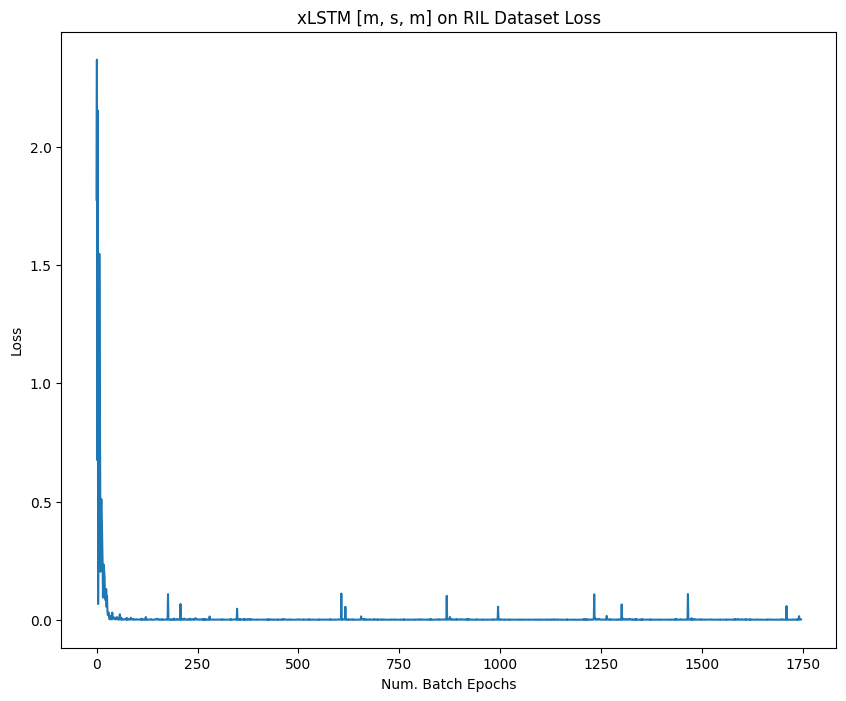

In [ ]:
plot_losses(losses, title='xLSTM [m, s, m] on RIL Dataset Loss')

In [ ]:
preds_xlstm_msm = get_preds(xlstm_stack, input_projection, output_projection, test_loader)

In [ ]:
mean_sq_err, mean_abs_err = get_mae_mse(testY, preds_xlstm_msm, mm)

mean_sq_err, mean_abs_err

(29.935153689069324, 1962.6721966663029)

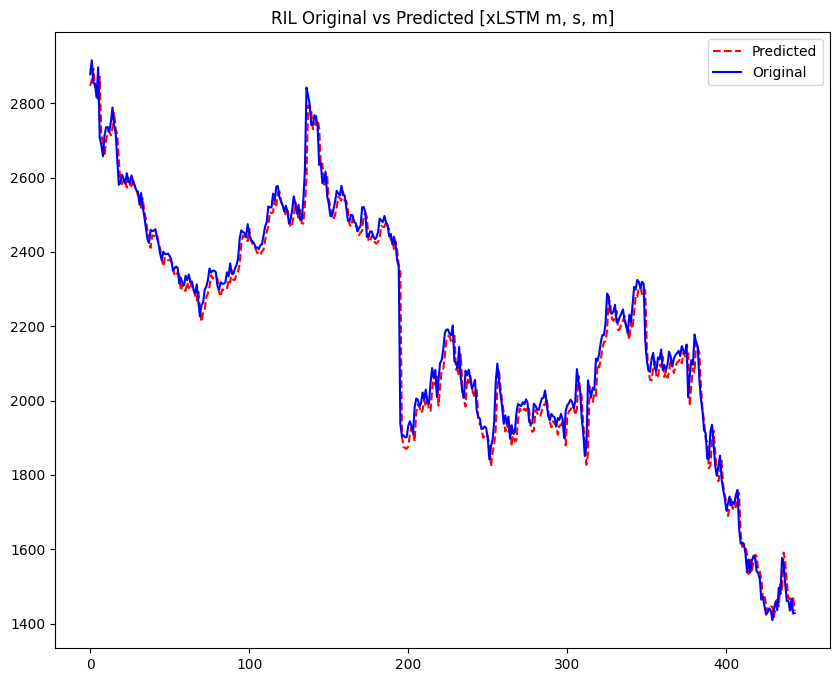

In [ ]:
plot_original_vs_predicted(testY, preds_xlstm_msm, mm, 'RIL Original vs Predicted [xLSTM m, s, m]')

## `[mms]` Structure

In [ ]:
from torch.optim import Adam

num_epochs = 5

xlstm_stack, input_projection, output_projection = create_xlstm_model(SEQUENCE_LENGTH, num_blocks=3, slstm_pos=[2])
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = Adam(list(xlstm_stack.parameters()) + list(input_projection.parameters()) + list(output_projection.parameters()), lr=0.0001)

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:543: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @conditional_decorator(
/usr/local/lib/python3.11/dist-packages/xlstm/blocks/slstm/cell.py:568: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @conditional_decorator(


In [ ]:
summary(xlstm_stack)

Layer (type:depth-idx)                             Param #
xLSTMBlockStack                                    --
├─ModuleList: 1-1                                  --
│    └─mLSTMBlock: 2-1                             --
│    │    └─LayerNorm: 3-1                         64
│    │    └─mLSTMLayer: 3-2                        27,524
│    └─mLSTMBlock: 2-2                             --
│    │    └─LayerNorm: 3-3                         64
│    │    └─mLSTMLayer: 3-4                        27,524
│    └─sLSTMBlock: 2-3                             --
│    │    └─LayerNorm: 3-5                         64
│    │    └─sLSTMLayer: 3-6                        16,896
│    │    └─LayerNorm: 3-7                         64
│    │    └─GatedFeedForward: 3-8                  24,576
├─LayerNorm: 1-2                                   64
Total params: 96,840
Trainable params: 96,840
Non-trainable params: 0

In [ ]:
losses = train_model(num_epochs, xlstm_stack, input_projection, output_projection, train_loader, optimizer, criterion, architecture="[m, m, s]")

Training xLSTM [m, m, s] for 5 epochs...


Epoch 1: Avg Loss = 0.007326


Epoch 2: Avg Loss = 0.001177


Epoch 3: Avg Loss = 0.001090


Epoch 4: Avg Loss = 0.001045


Epoch 5: Avg Loss = 0.001029

Architecture - [m, m, s] took 34.67 seconds to train.


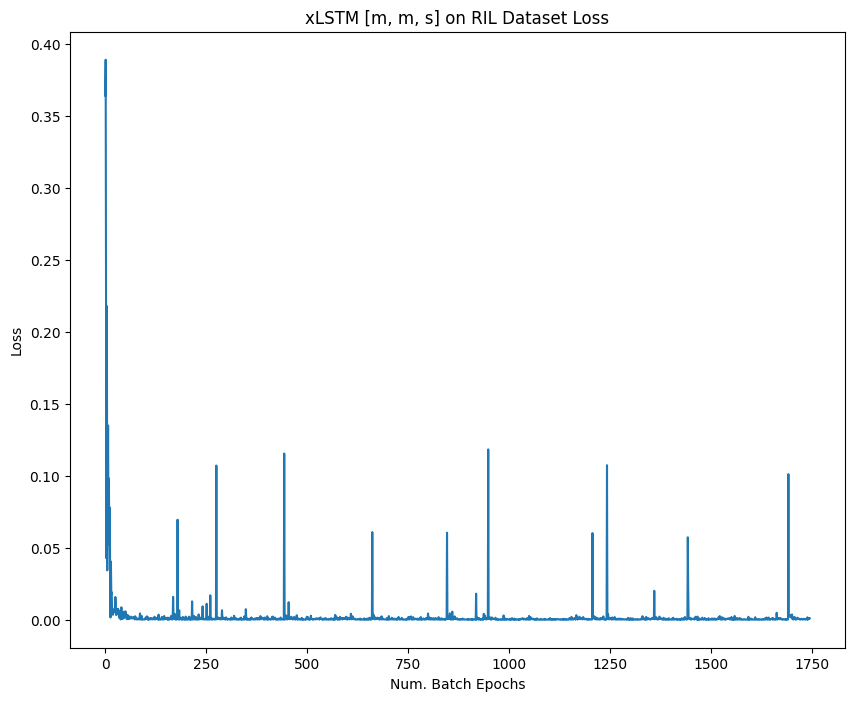

In [ ]:
plot_losses(losses, title='xLSTM [m, m, s] on RIL Dataset Loss')

In [ ]:
preds_xlstm_mms = get_preds(xlstm_stack, input_projection, output_projection, test_loader)

In [ ]:
mean_sq_err, mean_abs_err = get_mae_mse(testY, preds_xlstm_mms, mm)

mean_sq_err, mean_abs_err

(33.194122666546086, 2318.4566288888427)

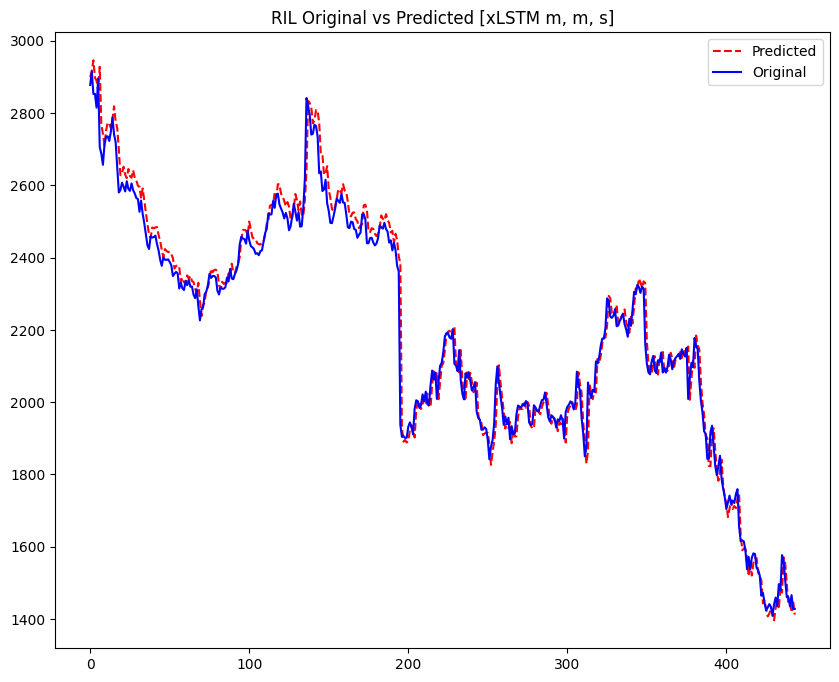

In [ ]:
plot_original_vs_predicted(testY, preds_xlstm_mms, mm, 'RIL Original vs Predicted [xLSTM m, m, s]')

## LSTM Model

In [ ]:
inp, targ = next(iter(train_loader))
inp.shape, targ.shape, targ

(torch.Size([3, 7, 1]),
 torch.Size([3, 1]),
 tensor([[0.6898],
         [0.6598],
         [0.6267]], device='cuda:0'))

In [ ]:
import torch
import torch.nn as nn

class StockPriceLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(StockPriceLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,       # 1 feature per time step
            hidden_size=hidden_size,     # hidden state size
            num_layers=num_layers,       # number of LSTM layers
            batch_first=True,            # input shape will be (batch, seq_len, input_size)
            dropout=dropout              # dropout between layers
        )

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, 1)  # final output is a single number

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)

        # Initialize hidden and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out shape: (batch_size, seq_length, hidden_size)

        # Use the output from the last time step
        last_time_step_output = out[:, -1, :]  # shape: (batch_size, hidden_size)

        # Pass through the final fully connected layer
        prediction = self.fc(last_time_step_output)  # shape: (batch_size, 1)

        return prediction


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

# Model initialization
model = StockPriceLSTM().to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training settings
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# For loss tracking
train_losses = []

start = time.perf_counter()
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for inp, targ in tqdm(train_loader, desc=f'Training LSTM Model on Epoch {epoch}'):
        inp, targ = inp.to(device), targ.to(device)

        # Forward pass
        outputs = model(inp)
        loss = criterion(outputs, targ)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

end = time.perf_counter()
print(f"Training LSTM Model took - {end - start:.3f} seconds")

Training LSTM Model on Epoch 0: 100%|██████████| 348/348 [00:01<00:00, 255.99it/s]


Epoch [1/5], Loss: 0.0162


Training LSTM Model on Epoch 1: 100%|██████████| 348/348 [00:01<00:00, 346.64it/s]


Epoch [2/5], Loss: 0.0037


Training LSTM Model on Epoch 2: 100%|██████████| 348/348 [00:00<00:00, 377.16it/s]


Epoch [3/5], Loss: 0.0033


Training LSTM Model on Epoch 3: 100%|██████████| 348/348 [00:00<00:00, 378.29it/s]


Epoch [4/5], Loss: 0.0027


Training LSTM Model on Epoch 4: 100%|██████████| 348/348 [00:00<00:00, 374.06it/s]

Epoch [5/5], Loss: 0.0028
Training LSTM Model took - 5.157 seconds


In [ ]:
def predict(model, test_data):
    """
    input_seq: Tensor of shape (1, seq_length, 1)
    Example: shape = (1, 7, 1) for a single sample
    """
    preds = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in test_data:
            prediction = model(inputs)
            prediction = prediction.squeeze()
            for pred in prediction:
                preds.append(pred.cpu().item())

    return np.array(preds).reshape(-1, 1)

In [ ]:
preds_lstm = predict(model, test_loader)

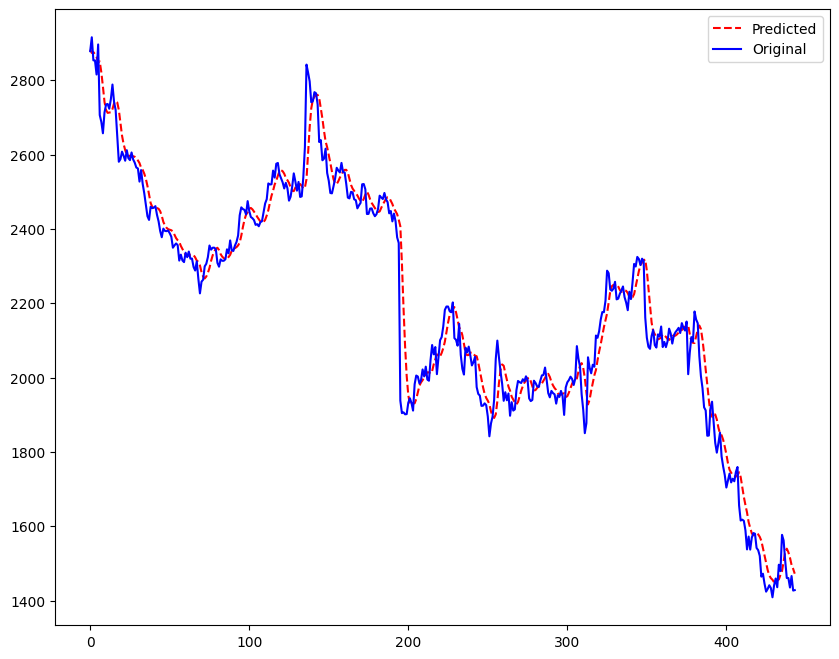

In [ ]:
plot_original_vs_predicted(original=testY, predicted=preds_lstm, scaler=mm)


In [ ]:
get_mae_mse(original=testY, predicted=preds_lstm, scaler=mm)

(42.58766222818751, 4077.1398067999467)

# GRU Model

In [ ]:
import torch
import torch.nn as nn

class StockPriceGRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(StockPriceGRU, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU layer
        self.gru = nn.GRU(
            input_size=input_size,       # 1 feature per time step
            hidden_size=hidden_size,     # hidden state size
            num_layers=num_layers,       # number of GRU layers
            batch_first=True,            # input shape will be (batch, seq_len, input_size)
            dropout=dropout              # dropout between layers
        )

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, 1)  # final output is a single number

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out shape: (batch_size, seq_length, hidden_size)

        # Use the output from the last time step
        last_time_step_output = out[:, -1, :]  # shape: (batch_size, hidden_size)

        # Pass through the final fully connected layer
        prediction = self.fc(last_time_step_output)  # shape: (batch_size, 1)

        return prediction

In [ ]:
# Model initialization for GRU
gru_model = StockPriceGRU().to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss function and optimizer for GRU
gru_criterion = nn.MSELoss()
gru_optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

# For loss tracking
gru_train_losses = []

# Training loop for GRU
start = time.perf_counter()
for epoch in range(num_epochs):
    gru_model.train()
    epoch_loss = 0.0

    for inp, targ in tqdm(train_loader, desc=f'Training GRU Model on Epoch {epoch}'):
        inp, targ = inp.to(device), targ.to(device)

        # Forward pass
        outputs = gru_model(inp)
        loss = gru_criterion(outputs, targ)

        # Backward pass and optimization
        gru_optimizer.zero_grad()
        loss.backward()
        gru_optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    gru_train_losses.append(avg_loss)
    print(f"GRU - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
end = time.perf_counter()
print(f'GRU Model Took - {end - start:.3f} seconds')

Training GRU Model on Epoch 0: 100%|██████████| 348/348 [00:00<00:00, 392.15it/s]


GRU - Epoch [1/5], Loss: 0.0097


Training GRU Model on Epoch 1: 100%|██████████| 348/348 [00:00<00:00, 398.00it/s]


GRU - Epoch [2/5], Loss: 0.0028


Training GRU Model on Epoch 2: 100%|██████████| 348/348 [00:00<00:00, 397.48it/s]


GRU - Epoch [3/5], Loss: 0.0023


Training GRU Model on Epoch 3: 100%|██████████| 348/348 [00:00<00:00, 404.05it/s]


GRU - Epoch [4/5], Loss: 0.0020


Training GRU Model on Epoch 4: 100%|██████████| 348/348 [00:00<00:00, 414.10it/s]

GRU - Epoch [5/5], Loss: 0.0020
GRU Model Took - 4.357 seconds


In [ ]:
preds_gru = predict(gru_model, test_loader)

get_mae_mse(testY, preds_gru, mm)

(62.29130968732492, 5509.840337398768)

# RNN Model

In [ ]:
import torch
import torch.nn as nn

class StockPriceRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(StockPriceRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Simple RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,       # 1 feature per time step
            hidden_size=hidden_size,     # hidden state size
            num_layers=num_layers,       # number of RNN layers
            batch_first=True,            # input shape will be (batch, seq_len, input_size)
            dropout=dropout              # dropout between layers
        )

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, 1)  # final output is a single number

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  # out shape: (batch_size, seq_length, hidden_size)

        # Use the output from the last time step
        last_time_step_output = out[:, -1, :]  # shape: (batch_size, hidden_size)

        # Pass through the final fully connected layer
        prediction = self.fc(last_time_step_output)  # shape: (batch_size, 1)

        return prediction


In [ ]:
# Model initialization for RNN
rnn_model = StockPriceRNN().to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss function and optimizer for RNN
rnn_criterion = nn.MSELoss()
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# For loss tracking
rnn_train_losses = []

# Training loop for RNN
start = time.perf_counter()
for epoch in range(num_epochs):
    rnn_model.train()
    epoch_loss = 0.0

    for inp, targ in tqdm(train_loader, desc=f'Training RNN Model on {epoch} Epoch'):
        inp, targ = inp.to(device), targ.to(device)

        # Forward pass
        outputs = rnn_model(inp)
        loss = rnn_criterion(outputs, targ)

        # Backward pass and optimization
        rnn_optimizer.zero_grad()
        loss.backward()
        rnn_optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    rnn_train_losses.append(avg_loss)
    print(f"RNN - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
end = time.perf_counter()

print(f"RNN Model Took - {end - start:.4f} seconds")

Training RNN Model on 0 Epoch: 100%|██████████| 348/348 [00:00<00:00, 448.48it/s]


RNN - Epoch [1/5], Loss: 0.0151


Training RNN Model on 1 Epoch: 100%|██████████| 348/348 [00:00<00:00, 448.64it/s]


RNN - Epoch [2/5], Loss: 0.0031


Training RNN Model on 2 Epoch: 100%|██████████| 348/348 [00:00<00:00, 364.11it/s]


RNN - Epoch [3/5], Loss: 0.0025


Training RNN Model on 3 Epoch: 100%|██████████| 348/348 [00:01<00:00, 341.73it/s]


RNN - Epoch [4/5], Loss: 0.0021


Training RNN Model on 4 Epoch: 100%|██████████| 348/348 [00:01<00:00, 342.18it/s]

RNN - Epoch [5/5], Loss: 0.0022
RNN Model Took - 4.5680 seconds


In [ ]:
preds_rnn = predict(rnn_model, test_loader)

get_mae_mse(testY, preds_rnn, mm)

(43.81481021461305, 3391.858496138351)

In [ ]:
def inv_trfm(preds, scaler):
    return scaler.inverse_transform(preds)

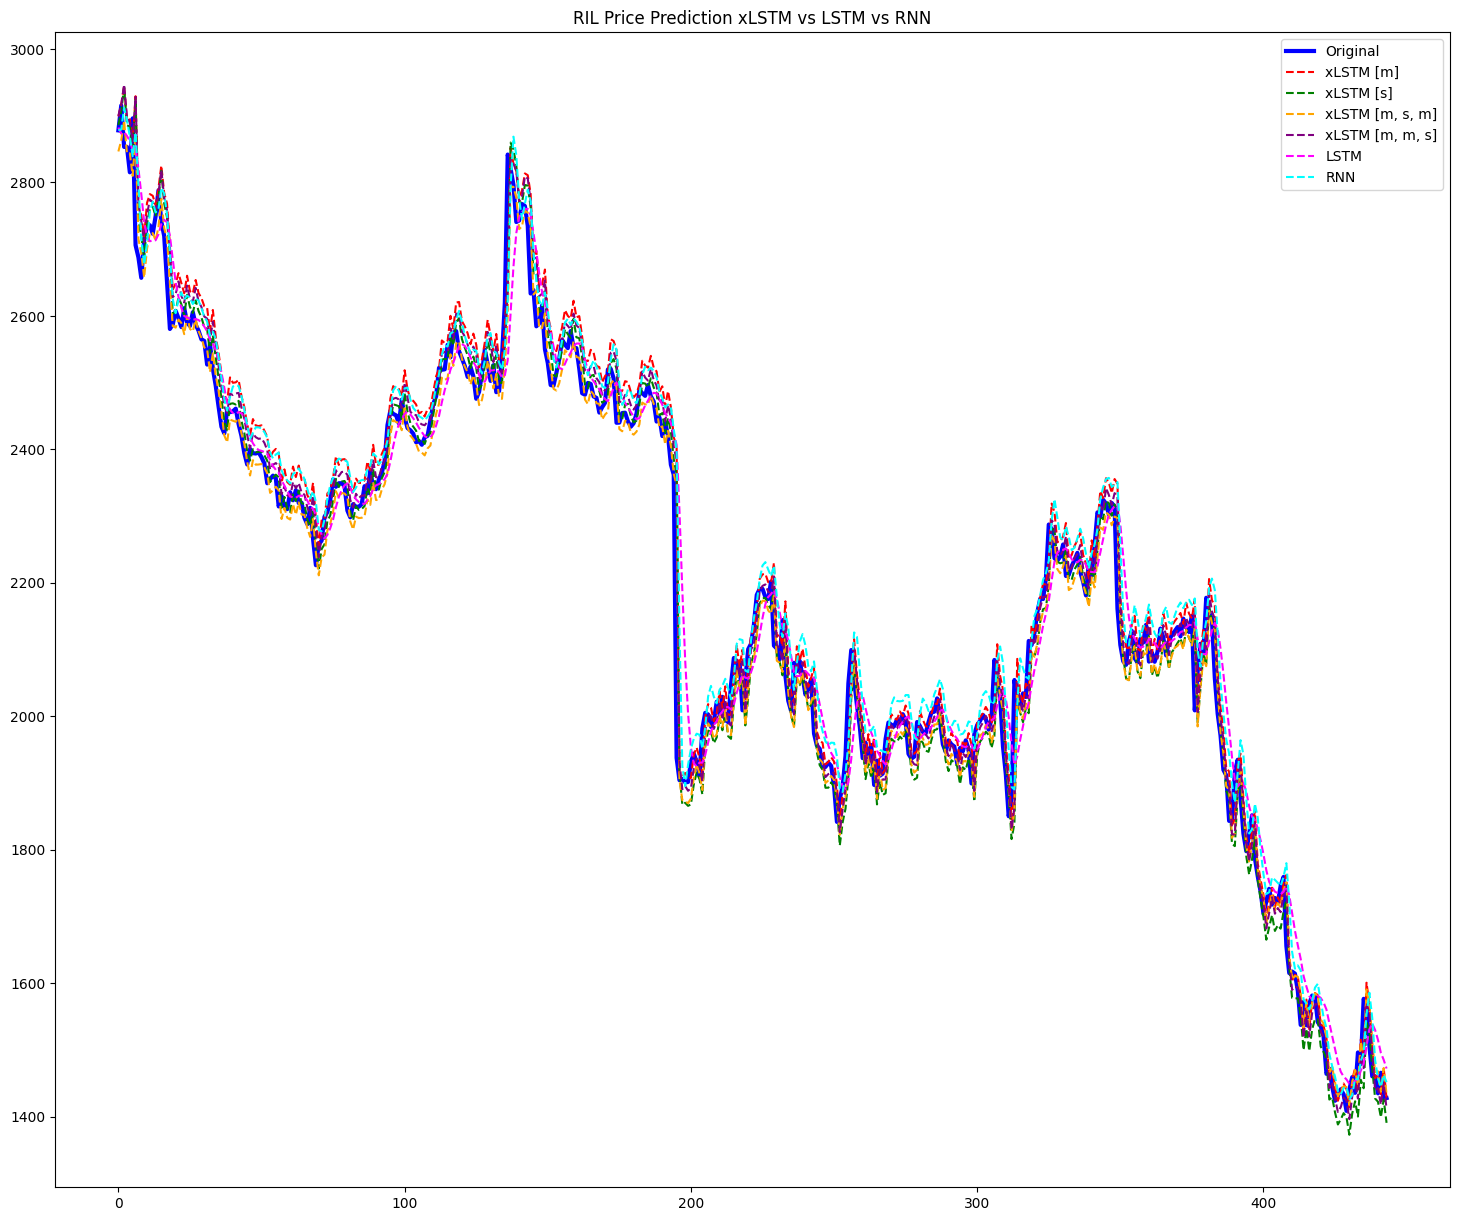

In [ ]:
plt.figure(figsize=(18, 15))
plt.title('RIL Price Prediction xLSTM vs LSTM vs RNN')

plt.plot(range(len(testY)), inv_trfm(testY.cpu().numpy(), mm), linewidth=3, c='b', label='Original')
plt.plot(range(len(preds_xlstm_m)), inv_trfm(preds_xlstm_m, mm), c='r', linestyle='--', label='xLSTM [m]')
plt.plot(range(len(preds_xlstm_s)), inv_trfm(preds_xlstm_s, mm), c='g', linestyle='--', label='xLSTM [s]')
plt.plot(range(len(preds_xlstm_msm)), inv_trfm(preds_xlstm_msm, mm), c='orange', linestyle='--', label='xLSTM [m, s, m]')
plt.plot(range(len(preds_xlstm_mms)), inv_trfm(preds_xlstm_mms, mm), c='purple', linestyle='--', label='xLSTM [m, m, s]')
plt.plot(range(len(preds_lstm)), inv_trfm(preds_lstm, mm), c='magenta', linestyle='--', label='LSTM')
plt.plot(range(len(preds_rnn)), inv_trfm(preds_rnn, mm), c='cyan', linestyle='--', label='RNN')

plt.legend()
plt.show()